In [52]:
import pandas as pd 
import numpy as np 
import seaborn as sns 

import warnings 
import pickle 
import re 
import gensim 
import spacy 

from sklearn.metrics.pairwise import cosine_similarity

from IPython.display import display
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess 
from tqdm import tqdm 

nlp = spacy.load('en_core_web_lg')
sns.set_style('darkgrid')
warnings.simplefilter('ignore')

In [44]:
df = pd.read_csv('../ds/dataset.csv').drop(columns=['Unnamed: 0'])
argument_matcher = pd.read_csv('../ds/descriptions.csv').drop(columns=['Unnamed: 0'])
all_reviews = pd.read_csv('../ds/all_review.csv')

display(all_reviews.sample(5))

display(df.sample(5))

display(argument_matcher.sample(5))

,city,reviews,description,rating,latitude,longitude,population,place,describer,rating_cls,complete_description
870,belgaum,Visited on my short stay in Belgaum. Amazing J...,‘Kamal Basadi’ also known as Kamal Basti is a...,4.500000,15.8667,74.5000,488157.0,Kamal Basti,visited short stay belgaum. amazing jain basad...,2.0,Visited on my short stay in Belgaum. Amazing J...
1045,jodhpur,Worst exepirence Rooms stayed were not at all ...,Splash - The Fun World is situated on the Sar...,2.000000,26.2918,73.0168,995000.0,Splash - The Fun World,worst exepirence rooms stayed properly maintai...,0.0,Worst exepirence Rooms stayed were not at all ...
1146,mangalore,Nice natural location We went to this temple m...,Kateel Shri Durgaparameshwari Temple is one o...,4.500000,12.8703,74.8806,623841.0,Kateel Durgaparameshwari Temple,nice natural location went temple mainly worsh...,2.0,Nice natural location We went to this temple m...
730,gurgaon,Green amongst concrete A must visit place if y...,"Expanding over 1.54 square kilometres, Araval...",4.500000,28.4500,77.0200,197340.0,Aravalli Biodiversity Park,green amongst concrete must visit local reside...,2.0,Green amongst concrete A must visit place if y...
1005,bhubaneswar,Very Big Shivalinga The temple is a combinatio...,The Brahmeshwara Temple is yet another relic ...,4.267442,20.2644,85.8281,837737.0,Brahmeshwara Temple,very big shivalinga temple combination beautif...,2.0,Very Big Shivalinga The temple is a combinatio...


,place,reviews,rating,location,description,lat,lng,country,iso2,admin_name,capital,population,population_proper,neg,neu,pos,compound
15912,Jagat Mandir,Lovely place for food lovers with ambience.,4.0,rajkot,If religious places often make their way to y...,22.2969,70.7984,India,IN,Gujarāt,NaN,1335397.0,1335397.0,0.000,0.410,0.590,0.8020
25981,Usha Kiran Palace Hotel,I had gone to Shalini Palace with my family ar...,3.0,gwalior,"Constructed in 1880 by the Scindia rulers, Us...",26.2150,78.1931,India,IN,Madhya Pradesh,NaN,1101981.0,1101981.0,0.079,0.794,0.127,0.8187
33538,Shivappa Nayaka Palace Museum,Lovely palace!,4.0,shimoga,"Lying on the banks of River Tunga, the Shivap...",13.9304,75.5600,India,IN,Karnātaka,NaN,654055.0,319550.0,0.000,0.196,0.804,0.6239
23634,Sadul Singh Museum,The displays of beautiful fabrics and outfits ...,4.0,bikaner,"Dedicated to the Maharajas of Bikaner, Mahara...",28.0181,73.3169,India,IN,Rājasthān,NaN,529007.0,529007.0,0.000,0.675,0.325,0.8620
26472,Aliyar Dam Reservoir Park,Looks like Local Hoteliers and traders have no...,3.5,coimbatore,Aliyar Dam Reservoir Park is situated adjacen...,11.0000,76.9667,India,IN,Tamil Nādu,NaN,959823.0,959823.0,0.062,0.738,0.199,0.5881


,place,0,1,2,3,4,5,6,7,8,...,190,191,192,193,194,195,196,197,198,199
57,Bhadra Fort,207.707750,8.636704,-91.902162,77.196533,67.779815,-86.749758,-75.446027,125.077652,72.897135,...,-10.009790,-55.680468,-53.942716,-24.016817,50.952812,-48.557856,-9.064006,-86.176265,-31.016647,100.822803
295,Krishnarajasagar Dam,165.603135,-23.626099,17.637505,-1.762001,92.223728,-73.914467,-86.838402,152.211044,69.033215,...,96.744971,-85.552180,25.860553,-36.964131,44.821644,84.878264,110.123691,-50.840689,26.792009,27.100412
81,Bahu Fort,425.327594,-118.041344,-169.367099,97.939888,201.380743,-351.020964,120.075857,484.213987,108.115685,...,216.872791,-44.841001,-201.314514,-66.524184,58.718359,89.010916,123.507151,-342.210204,-21.800857,25.738897
152,Sisodia Rani Garden,71.175862,-25.093737,64.914903,23.775353,90.533682,-57.791976,-28.871558,132.077169,53.400909,...,96.701299,-67.276332,-87.870227,-12.381610,53.786413,-38.371420,-11.048823,-95.392028,6.721002,89.039964
52,AUDA Garden,112.392159,-34.244540,91.943050,-11.675798,52.628603,-93.169202,-40.860839,162.167744,101.053050,...,121.845131,-83.355794,7.893081,-140.222581,19.835349,74.313759,90.258075,-91.774473,7.971539,6.991190


In [111]:
with open('word2vec.pkl', 'rb') as f:
    model = pickle.load(f)

def similarity(vector_input, vector_description):
    return cosine_similarity(vector_input.reshape(1, -1), vector_description.values.reshape(1, -1))

def recommend(description):
    descriptions = argument_matcher.copy()
    vector = 0 
    for word in simple_preprocess(description):
        try:
            vector += model.wv[word]
        except Exception as E:
            pass 

    descriptions['similarity'] = descriptions.apply(lambda x: similarity(vector, x[-200:])[0][0], axis = 1)

    display(descriptions.sort_values(by = 'similarity', ascending=False).iloc[:, [0, -1]])

    

    # display(argument_matcher.sort_values(by = ['similarity'])) 

recommend('I want to go to a border')

,place,similarity
220,Wagah Border,0.810400
1246,Nathula Pass,0.783069
1117,Kali Mata Ka Mandir,0.754101
312,Auroville,0.744728
102,SkyHigh,0.743129
...,...,...
932,Roop Singh Stadium,0.022010
362,Vedvyas,-0.000859
759,Parikshith Thampuran Museum,-0.024293
31,Prakasam Salai,-0.065563


In [61]:
%%timeit
review = all_reviews.iloc[5, 1]

nlp(u'{}'.format(review)).vector

70.3 ms ± 8.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [109]:
vec_review = []

for value in tqdm(all_reviews.reviews.values):
    vec_review.append(nlp(u'{}'.format(value)).vector)



100%|██████████| 1397/1397 [02:12<00:00, 10.52it/s]


In [ ]:
vec_description = []
for desc in tqdm(all_reviews.description.values):
    vec_description.append(nlp(u'{}'.format(desc)).vector)


100%|██████████| 1397/1397 [00:19<00:00, 73.23it/s]


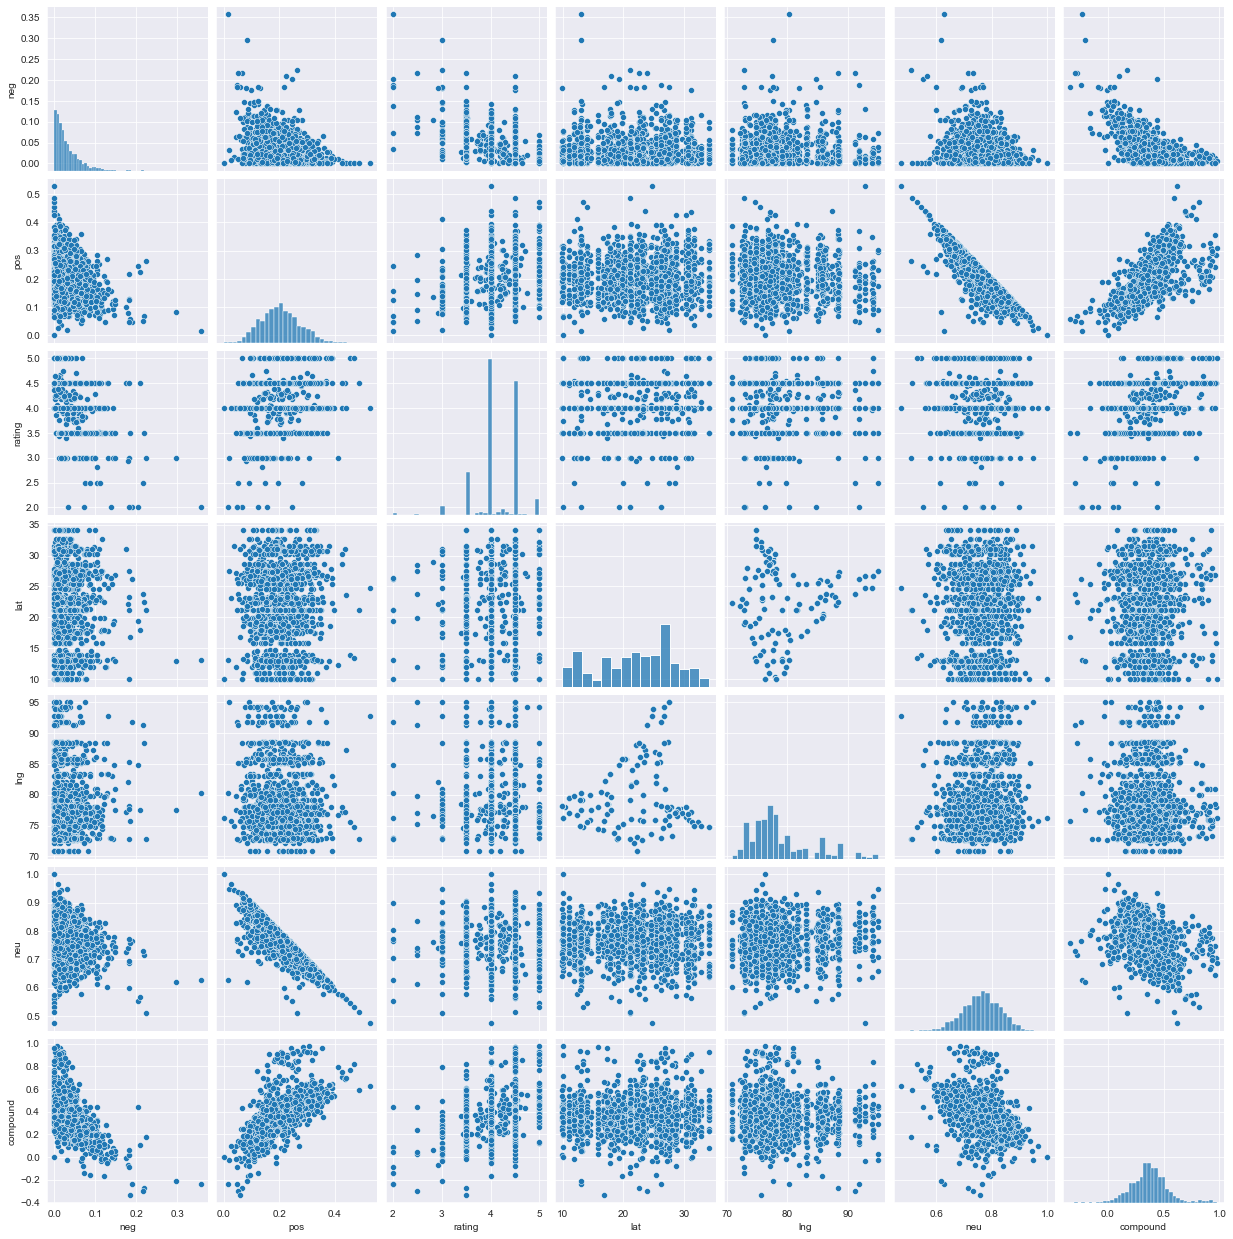

In [69]:
standards = df.groupby('place')['neg', 'pos', 'rating', 'lat', 'lng', 'neu', 'compound'].mean().reset_index()
sns.pairplot(standards)

In [112]:
places = all_reviews.place.values
desc_df = pd.DataFrame(np.hstack((places.reshape(-1, 1), np.array(vec_description))), columns=['place'] + list(range(300))) 
review_df = pd.DataFrame(np.hstack((places.reshape(-1, 1), np.array(vec_review))), columns=['place'] + list(range(300)))

def similarity(vector_input, vector_description):
    return cosine_similarity(vector_input.reshape(1, -1), vector_description.values.reshape(1, -1))[0][0]

def recommend(description):
    dataset = standards.copy()
    reviews = review_df.copy()
    descriptions = desc_df.copy()
    
    vector = nlp(u'{}'.format(description)).vector

    reviews['similarity'] = reviews.apply(lambda x: similarity(vector, x[-300:]), axis = 1)
    descriptions['similarity'] = descriptions.apply(lambda x: similarity(vector, x[-300:]), axis = 1)
    dataset['review_similarity'] = reviews.similarity
    dataset['descript_similarity'] = descriptions.similarity

    display(dataset.sort_values(by = ['descript_similarity', 'review_similarity'], ascending=False).loc[:, ['place', 'descript_similarity', 'pos', 'review_similarity']].head(20))


    # display(argument_matcher.sort_values(by = ['similarity'])) 

recommend('I want to go to a temple')

,place,descript_similarity,pos,review_similarity
300,Doodh Talai Musical Garden,0.739525,0.165913,0.661767
716,MGF Mall,0.710693,0.244750,0.617063
1193,Sri Laxminath Temple,0.681100,0.255300,0.601254
739,Maharana Pratap Smarak,0.674364,0.242895,0.628291
485,ISKCON Raipur - Sri Radha Rasbihari Temple,0.673056,0.300429,0.560058
385,Gobind Sagar Lake,0.666786,0.253690,0.690765
353,Funtasia Island,0.665423,0.206649,0.737724
1258,Tapkeshwar Temple,0.664515,0.175095,0.670534
1124,Shamirpet Lake,0.659676,0.211050,0.655539
611,Kashi Vishwanath Temple,0.652570,0.145292,0.700780


In [87]:
np.hstack((places.reshape(-1, 1), np.array(vec_review)))

array([['Rai Praveen Mahal', -1.5166232585906982, 0.9801996350288391,
        ..., -1.0559171438217163, -3.1837096214294434,
        1.0622949600219727],
       ['Barua Sagar', -0.98725426197052, 0.9908755421638489, ...,
        -0.7160965800285339, -2.7207088470458984, 1.3719667196273804],
       ['Parichha Dam', -1.1460355520248413, 0.2847311198711395, ...,
        -1.1897586584091187, -2.0021328926086426, 0.886434018611908],
       ...,
       ['Padum Pukhuri', -1.4639849662780762, 1.0604809522628784, ...,
        -1.391063928604126, -2.434387683868408, 1.3190670013427734],
       ['Kolia Bhomora Setu', -1.5945782661437988, 0.6533769369125366,
        ..., -1.252103328704834, -2.4709713459014893, 0.9718573689460754],
       ['Bura Chapori Wildlife Sanctuary', -1.4347882270812988,
        0.45670121908187866, ..., -0.7410643696784973, -2.41062331199646,
        1.1170871257781982]], dtype=object)

In [85]:
np.array(vec_review).shape

(43, 300)